In [ ]:
# I will explain each part in details to you when i complete this project 

In [1]:
import numpy as np
import torch 
from torch.utils.data import Dataset , DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , accuracy_score
import cv2
import random
import sys

In [2]:
tumor=[]
path='./dataset/yes/*.jpg'
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b, g, r=cv2.split(img)
    img=cv2.merge([r , g , b])
    tumor.append(img)
    

In [3]:
len(tumor)

704

In [4]:
# for img in tumor:
#     print(img.shape)

In [5]:
health=[]
path='./dataset/no/*.jpg'
for f in glob.iglob(path):
    img=cv2.imread(f)
    img=cv2.resize(img , (128 , 128))
    b, g, r=cv2.split(img)
    img=cv2.merge([r , g , b])
    health.append(img)

In [6]:
# Converting into numpy array 
health=np.array(health)
tumor=np.array(tumor)

In [7]:
health.shape

(2000, 128, 128, 3)

In [8]:
tumor.shape
health.shape
All=np.concatenate((health , tumor))

In [9]:
All.shape

(2704, 128, 128, 3)

# Visualizing the image 


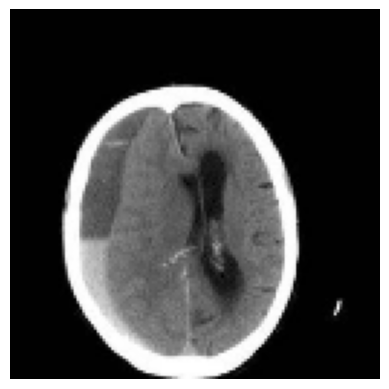

In [10]:
plt.imshow(health[0])
plt.axis('off') 
plt.show()

In [11]:
# Create a fucntion which select 5 random image from each set of nupy array 

In [12]:
def plot_random(health , tumor , num=5):
    health_images = health[np.random.choice(len(health) , num , replace=False)]
    tumor_images=tumor[np.random.choice(len(tumor) , num, replace=False)]
    plt.figure(figsize=(16 , 9))
    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title("Health_images")
        plt.imshow(health_images[i])
        
    plt.figure(figsize=(16 , 9))
    for i in range(num):
        plt.subplot(1 , num , i+1)
        plt.title("Tumor images")
        plt.imshow(tumor[i])    
            

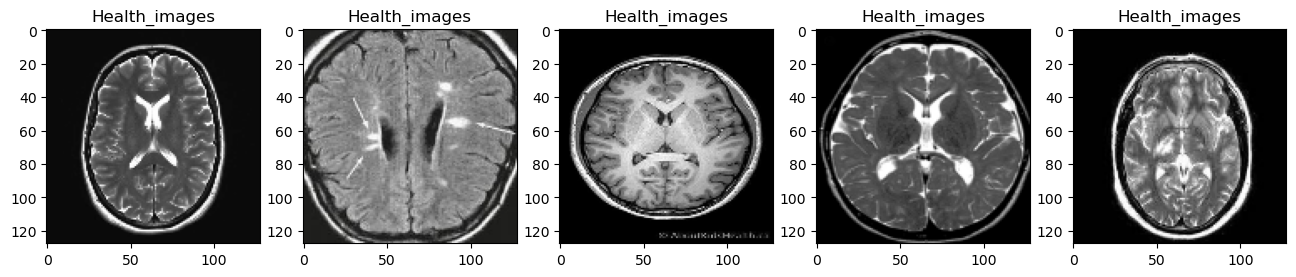

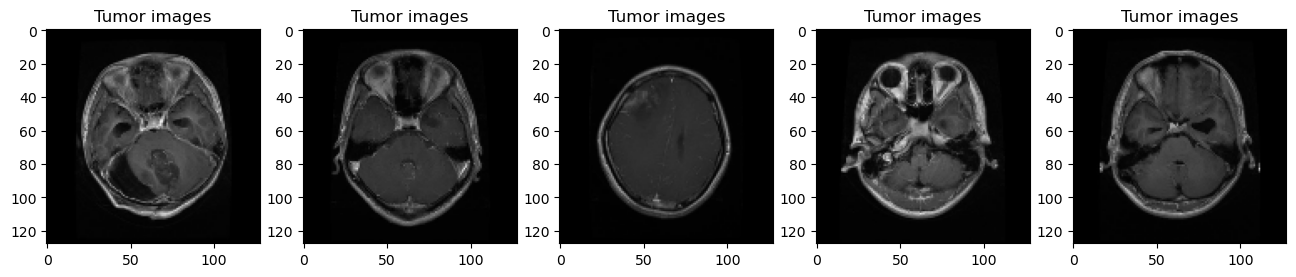

In [13]:
plot_random(health, tumor , 5)

In [14]:
class Dataset(object):
     def __getitem__(self, index):
         raise NotImplementedError
     def __len__(self):
         raise NotImplementedError
     def __add__(self , other):
         return ConcatDataset([self , other])

In [15]:
# For example to teach you
class test(Dataset):
    def __init__(self, scores):
        self.x=scores
    def __getitem__(self , index):
        return self.x[index]
    def __len__(self):
        return len(self.x)
    def __add__(self, x):
        return ConcatDataset([self ,x])

In [16]:
scores=[1,2 ,3,4,5]
d=test(scores)
d.x
scores_2=[400 , 500 , 400 , 500, 300]
d2=test(scores_2)

Creating actual class for it 

In [17]:
class MRI(Dataset):
    def __init__(self):
        tumor=[]
        path='./dataset/yes/*.jpg'
        for f in glob.iglob(path):
            img=cv2.imread(f)
            img=cv2.resize(img , (128 , 128))
            b, g, r=cv2.split(img)
            img=cv2.merge([r , g , b])
            tumor.append(img)
    
        health=[]
        path='./dataset/no/*.jpg'
        for f in glob.iglob(path):
            img=cv2.imread(f)
            img=cv2.resize(img , (128 , 128))
            b, g, r=cv2.split(img)
            img=cv2.merge([r , g , b])
            health.append(img)

        health=np.array(health)
        tumor=np.array(tumor)

        # now label images 1 with tumor 0 for with out tumor
        tumor_label=np.ones(tumor.shape[0] , dtype=np.float32)
        health_label=np.zeros(health.shape[0] ,  dtype=np.float32)
        
        self.images=np.concatenate((health , tumor) , axis=0)
        self.label=np.concatenate((tumor_label , health_label))
    def __len__(self):
        return  self.images.shape[0]
    def __getitem__(self , index):
        sample={'image':self.images[index] , 'labels':self.label[index] }
        return sample
    def normalize(self):
        self.images=self.images/255.0


In [18]:
mri=MRI()

In [19]:
mri.normalize()

In [20]:
img=mri[5]['image']

In [21]:
np.max(img)

np.float64(0.7843137254901961)

In [22]:
# index =list(range(len(mri)))
# # u can shuffle it by using random library 
# random.shuffle(index)
# # now u want to plot the image randomly 
# for idx in index:
#     sample=mri[idx]
#     img=sample['image']
#     # img=img.reshape(img.shape[2] , img.shape[1] , img.shape[0])
#     plt.imshow(img)
#     plt.show()


The world with dataloader

In [23]:
dataloader=DataLoader(mri , shuffle=True , batch_size=10)

In [24]:
for sample in dataloader:
    img=sample['image']
    img = img.permute(0, 3, 1, 2)
    print(img.shape)
    sys.exit()

torch.Size([10, 3, 128, 128])


SystemExit: 

C:\Users\za220\anaconda3\envs\BrainTumor\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
# Now define the model 
import torch.nn as nn 
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model=nn.Sequential(
            nn.Conv2d(in_channels=3 , out_channels=6 , kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2 , stride=5),
            nn.Conv2d(in_channels=6 , out_channels=16 , kernel_size=5), 
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2 , stride=5),
        )
        self.fc_model=nn.Sequential(
            nn.Linear(in_features=256 , out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120 , out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84 , out_features=1),
            nn.Tanh())

 
    def forward(self , x):
        x=self.cnn_model(x)
        # x=x.view(x.size(0) , -1)
        x = x.contiguous().view(x.size(0), -1)
        x=self.fc_model(x)
        x = torch.sigmoid(x)


        return x
        
        

In [26]:
model =CNN()


In [27]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [28]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [29]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [30]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[-0.0364,  0.0536, -0.0361, -0.0752,  0.0191],
          [-0.1061, -0.0321,  0.1040,  0.0578,  0.1120],
          [ 0.0855, -0.0232,  0.0567, -0.0644, -0.0562],
          [-0.0958, -0.1111, -0.0925, -0.1077,  0.0046],
          [-0.0943, -0.0754, -0.0656,  0.0935, -0.0904]],

         [[ 0.1012, -0.0217, -0.0422, -0.0943, -0.0265],
          [ 0.0467, -0.1078, -0.0221,  0.1131,  0.1091],
          [-0.0708,  0.0188,  0.0987,  0.0083,  0.0990],
          [-0.0107,  0.0313,  0.0481,  0.0688, -0.0357],
          [-0.0043,  0.0749, -0.0207,  0.0892,  0.0951]],

         [[ 0.0195,  0.0706,  0.0153,  0.1148,  0.0378],
          [-0.0296,  0.0809, -0.0589, -0.0142,  0.0018],
          [ 0.1083,  0.0435,  0.0346,  0.1064, -0.0446],
          [-0.0916,  0.0121, -0.0702,  0.0561,  0.0516],
          [-0.0786,  0.1084, -0.0650,  0.0358, -0.0796]]],


        [[[-0.0665,  0.0654,  0.0969, -0.0323,  0.1093],
          [ 0.0020,  0.1087, -0.0523, -0.0321, -0.0758],
 

In [31]:
# Learn one thing kernel_size is 5 x 5 grid which moves over the images and extract texture , pattern , edges , horizontal , veritical recognition
# out_comes what is out_come this the third dimension of the image which we keep on increasing on layer by layer why we are increasing i will tell on detail 
#Dont worry about it 

In [32]:
# I do not know why both are on cpu right know i trying to convert all of my data and model on the same gpu other wise they cannot communicate
# with each other 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu_tensor=torch.rand(10)
gpu_tensor=cpu_tensor.to(device)

print(cpu_tensor ,  cpu_tensor.type())
print(gpu_tensor , gpu_tensor.type())

tensor([0.4720, 0.1317, 0.6419, 0.8401, 0.2075, 0.3890, 0.6474, 0.5344, 0.9254,
        0.6401]) torch.FloatTensor
tensor([0.4720, 0.1317, 0.6419, 0.8401, 0.2075, 0.3890, 0.6474, 0.5344, 0.9254,
        0.6401], device='cuda:0') torch.cuda.FloatTensor


In [33]:
# Tensor multiply with each other when they are of same type other wise they dont multiply
print(cpu_tensor * gpu_tensor)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### Evaluate dumb model neural network 

In [34]:
# How can we achieve this hold on come with me 

In [35]:
mri_dataset=MRI()

In [36]:
mri_dataset.normalize()

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)



In [38]:
dataloader=DataLoader(mri_dataset , batch_size=32 , shuffle=False)

In [39]:
model.eval()
output=[]
y_true=[]
with torch.no_grad():
    for D in dataloader:
        
        image=D['image'].to(device).float()
        image = image.permute(0, 3, 1, 2).contiguous()

        # image= image.reshape(image.shape[0] , image.shape[1], image.shape[2])
        label=D['labels'].to(device).float()
        y_hat=model(image)
        output.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())  
    


In [40]:
output=np.concatenate(output , axis=0).squeeze() # convert it into single array prev its shape was 2704 , 1 we convert into 2704 ,0
y_true=np.concatenate(y_true , axis=0).squeeze()

In [41]:
if np.array_equal(y_true, mri_dataset.label):
    print("True")



True


In [42]:
output[0:5]

array([0.48025653, 0.48231357, 0.4787133 , 0.48237288, 0.4781877 ],
      dtype=float32)

In [43]:
output.shape 

(2704,)

In [44]:
def threshold(scores ,threshold=0.5 , minimum=0 , maximum=1):
    x=np.array(list(scores))
    x[x>threshold]=maximum
    x[x<threshold]=minimum
    return x

In [45]:
v=threshold(output)
v[0:120]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [46]:
# lets check its accuracy 


In [47]:
print(type(mri_dataset.label))

<class 'numpy.ndarray'>


In [48]:
accuracy_score(y_true ,v)

0.7396449704142012

In [49]:
# as u can see dumb model accuracy is arounf 20 percent fuck fuck very beautifully fucked up 

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (1).

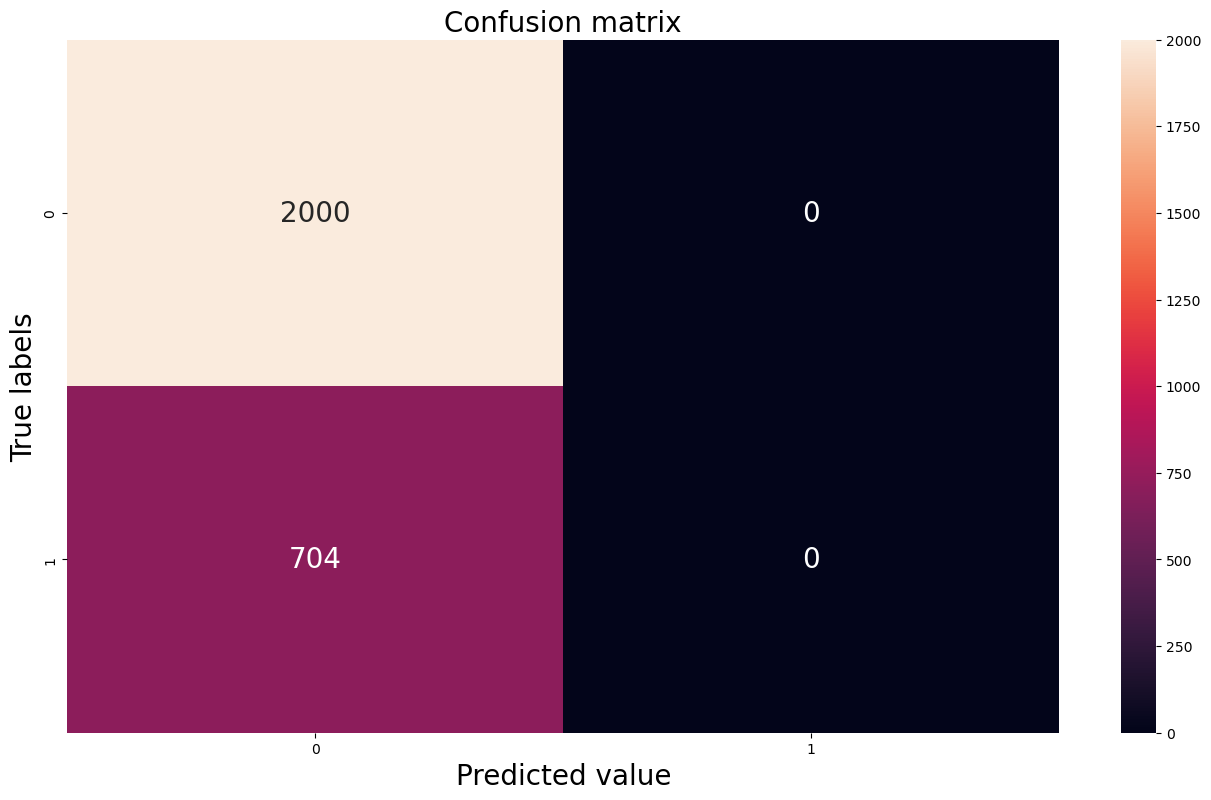

In [50]:
import seaborn as sns 
plt.figure(figsize=(16 , 9))

cm=confusion_matrix(y_true , threshold(output))
ax=plt.subplot()
sns.heatmap(cm , annot=True , fmt='g' , ax=ax , annot_kws={'size' : 20})

ax.set_xlabel('Predicted value' , fontsize=20)
ax.set_ylabel('True labels' , fontsize=20)
ax.set_title('Confusion matrix' , fontsize=20)
ax.xaxis.set_ticklabels(['Health , Tumor'] , fontsize=20)
ax.yaxis.set_ticklabels(['Tumor' , 'Health'] , fontsize=20)

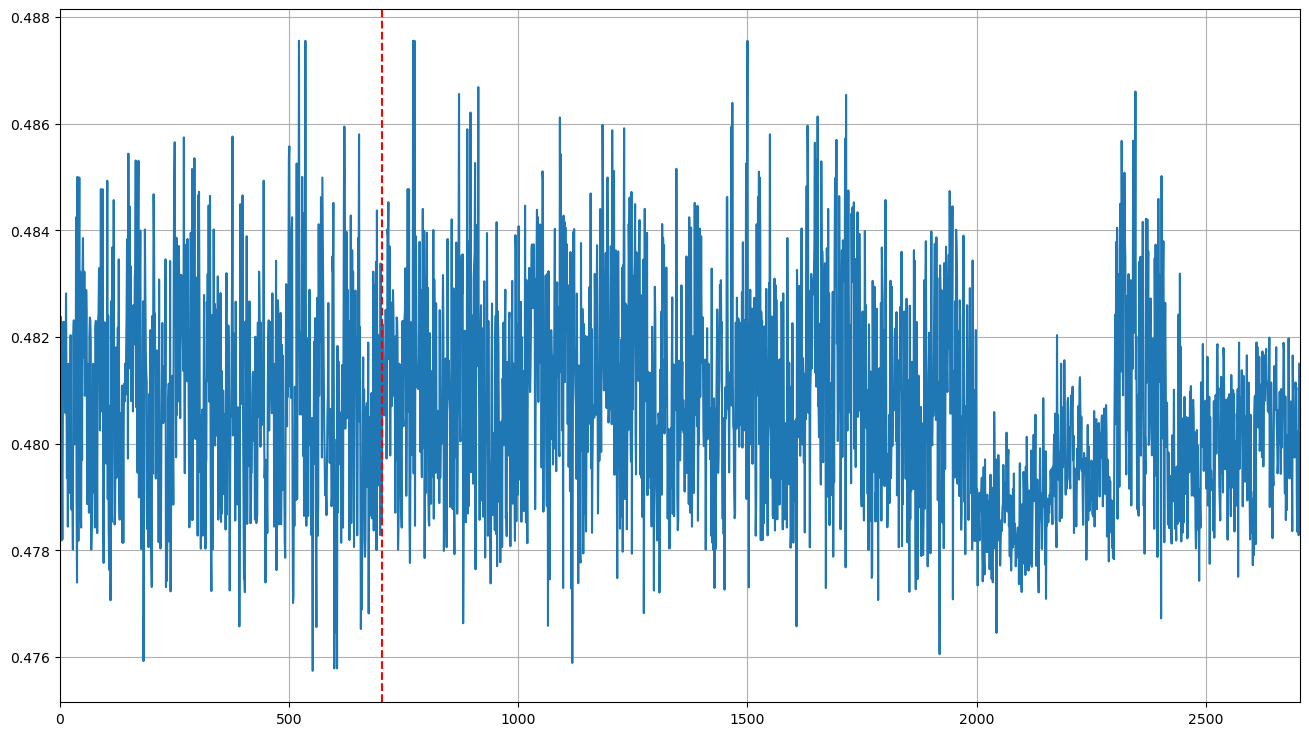

In [51]:
plt.figure(figsize=(16 , 9))
plt.plot(output)
plt.xlim(0 , 2704)
plt.axvline(x=len(tumor) , color='r' , linestyle='--')
plt.grid()
plt.show()

Lets train the model 

What we actually need to train the model
1-> Learning rate
2-> Optimizer 
3-> Dataloader 
4-> Here u are gonna using model.train or model.fit what ever it may be 

In [52]:
eta=0.0005
EPOCHS=100
optimizer= torch.optim.Adam(model.parameters() , lr=eta)
dataloader=DataLoader(mri_dataset , batch_size=32 , shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [53]:
for epcohs in range(1 , EPOCHS):
    lossess=[]
    for D in dataloader:
        
        data=D['image'].to(device).float()
        data = data.permute(0, 3, 1, 2).contiguous()
        
        label=D['labels'].to(device).float()
        y_hat=model(data).squeeze()
        # print(y_hat.shape)
        # print(label.shape)
        # sys.exit()
        # i make sure dimensionality should match why i will tell u
        # Define loss function
        error=nn.BCELoss()
        loss=torch.sum(error(y_hat.squeeze() , label))
        loss.backward()
        optimizer.step()
        lossess.append(loss.item())
    if(epcohs+1) % 10==0:
        print('Train epochs: {}\toss: {:.6f}'.format(epcohs+1 , np.mean(lossess)))
        



Train epochs: 10	oss: 0.574291
Train epochs: 20	oss: 0.573188
Train epochs: 30	oss: 0.573923
Train epochs: 40	oss: 0.573556
Train epochs: 50	oss: 0.572820
Train epochs: 60	oss: 0.574659
Train epochs: 70	oss: 0.573556
Train epochs: 80	oss: 0.573556
Train epochs: 90	oss: 0.573188
Train epochs: 100	oss: 0.573923


In [54]:
model.eval()
output_1=[]
y_true_2=[]
dataloader=DataLoader(mri_dataset , batch_size=32 , shuffle=False)
with torch.no_grad():
    for D in dataloader:
        
        image=D['image'].to(device).float()
        image = image.permute(0, 3, 1, 2).contiguous()

        # image= image.reshape(image.shape[0] , image.shape[1], image.shape[2])
        label=D['labels'].to(device).float()
        y_hat=model(image)
        output_1.append(y_hat.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())  
    


In [55]:
output_1=np.concatenate(output_1 , axis=0).squeeze() # convert it into single array prev its shape was 2704 , 1 we convert into 2704 ,0
y_true_2=np.concatenate(y_true_2 , axis=0).squeeze()

In [56]:
output_1

array([0.26894143, 0.26894143, 0.26894143, ..., 0.26894143, 0.26894143,
       0.26894143], dtype=float32)

In [57]:
accuracy_score(y_true_2 , threshold(output_1))

0.7396449704142012